In [1]:
from fastai.metrics import error_rate
from fastai.vision import *
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import pokepy

# Loading information about the Pokémon

In [2]:
client = pokepy.V2Client(cache='in_disk', cache_location='/home/jupyter')
img_dir = '/home/jupyter/fastai-explorations/data/pokemon'
img_path = Path(img_dir)
fnames = os.listdir(img_path)

In [3]:
def process_image_fname(f):
    id = f[:-4]
    if '-' not in id:
        try:
            poke = client.get_pokemon(id)
            return (poke[0].name, [t.type.name for t in poke[0].types])
        except:
            pass
    return (None, None)

In [4]:
df = [process_image_fname(f) for f in tqdm(fnames)]
df = pd.DataFrame(df, columns=['name', 'types'])

df['fname'] = fnames
df['id'] = [f[:-4] for f in fnames]
pd.to_numeric(df['id'], errors='coerce')
df.sort_values('id', inplace=True)
df.reset_index(inplace=True)

df['primary_type'] = df.types.map(lambda x: x[0] if x is not None else None)

100%|██████████| 820/820 [00:05<00:00, 158.33it/s]


# Loading image data

In [5]:
data = ImageDataBunch.from_df(
    img_path,
    df[~df.isnull().any(axis=1)],
    fn_col='fname', label_col='types', ds_tfms=get_transforms(), size=224)

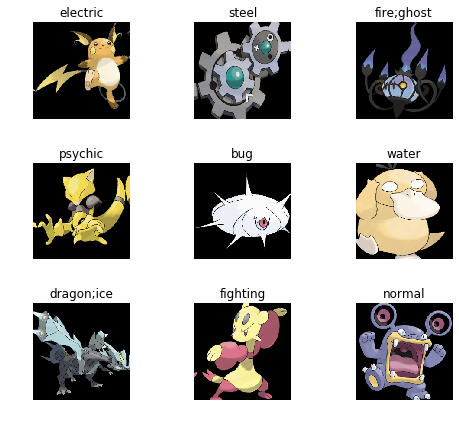

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']


(18, 18)

# Training resnet34

In [8]:
def fixed_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long()
    return (input==targs).float().mean()

In [9]:
learn = create_cnn(data, models.resnet34, metrics=fbeta)

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,fbeta
1,0.833514,0.767273,0.309412
2,0.783517,0.645197,0.308702
3,0.722994,0.556977,0.315759
4,0.673888,0.528351,0.319596


In [11]:
learn.save('stage-1')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

In [13]:
losses, idxs = interp.top_losses()

In [14]:
len(data.valid_ds) == len(losses)

False

In [15]:
len(losses) == len(idxs)

True

In [16]:
data.valid_ds

LabelList (140 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
bug,ghost;dark,flying;normal,poison,fire
Path: /home/jupyter/fastai-explorations/data/pokemon

In [17]:
len(losses), len(idxs)

(2520, 2520)

In [18]:
doc(interp.plot_multi_top_losses)

96 misclassified samples over 140 samples in the validation set.


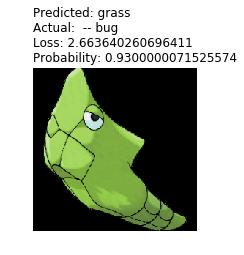

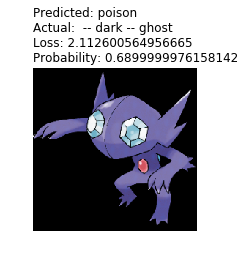

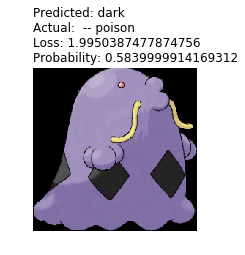

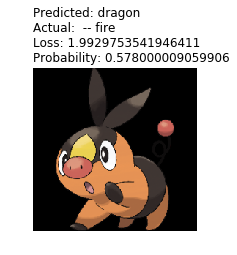

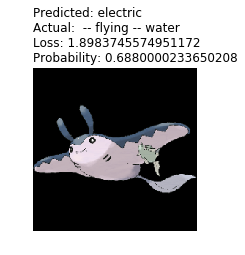

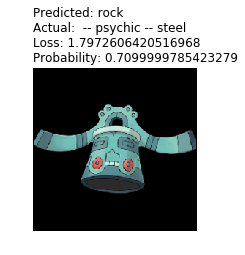

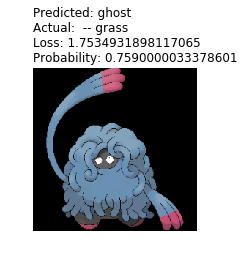

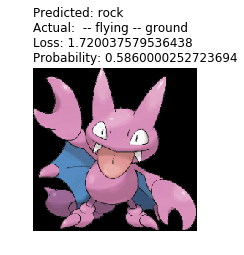

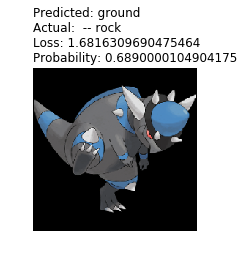

In [19]:
# interp.plot_top_losses(9, figsize=(15,11))
interp.plot_multi_top_losses(9, figsz=(3, 3))

In [20]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
# interp.most_confused(min_val=2)

# Unfreezing and fine-tuning learning rates

Because hand-drawn Pokémon cartoons are probably very different than what `resnet` was trained on, we should expect to use a relatively high learning rate to improve the results of our neural network.

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-02


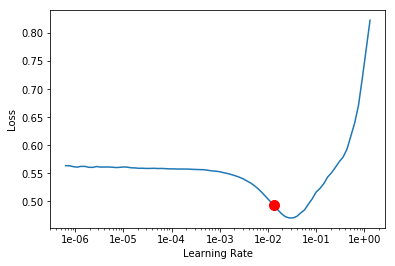

In [23]:
learn.recorder.plot()

In [24]:
learn.load('stage-1');

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.550660,0.489231,0.326286
2,0.530514,0.469079,0.333719


In [26]:
learn.save('stage-2')

90 misclassified samples over 140 samples in the validation set.


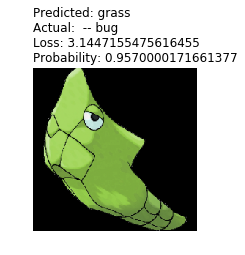

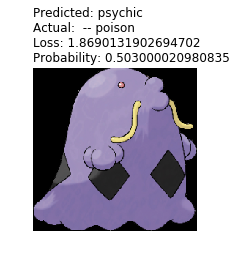

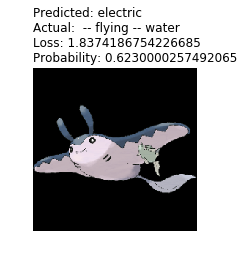

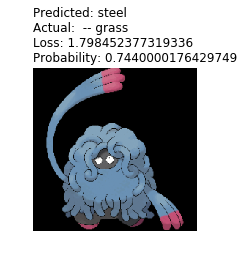

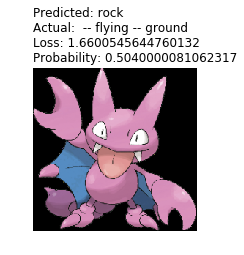

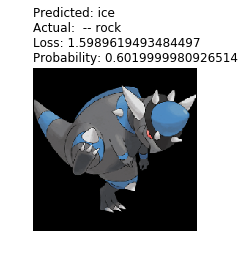

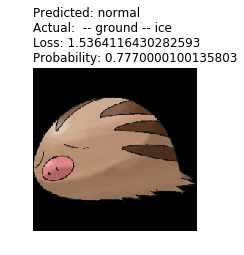

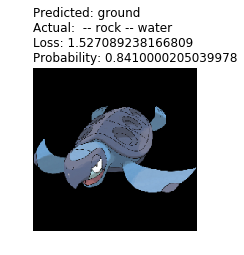

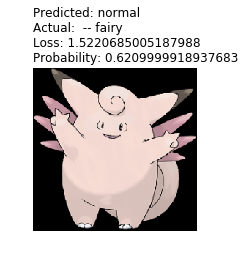

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_multi_top_losses(9, figsz=(3, 3))

# Training resnet50

In [28]:
learn50 = create_cnn(data, models.resnet50, metrics=fbeta)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


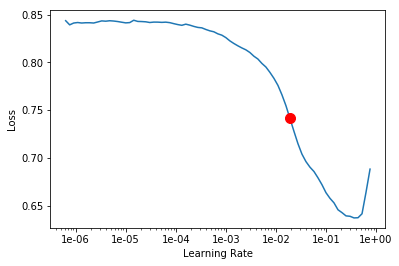

In [29]:
learn50.lr_find()
learn50.recorder.plot()

In [30]:
learn50.fit_one_cycle(8)

epoch,train_loss,valid_loss,fbeta
1,0.830329,0.717135,0.307053
2,0.790994,0.686170,0.313398
3,0.738872,0.569930,0.330189
4,0.663213,0.428526,0.348742
5,0.579342,0.315478,0.408802
6,0.503037,0.266642,0.432034
7,0.443189,0.253006,0.448445
8,0.397120,0.251195,0.449094


67 misclassified samples over 140 samples in the validation set.


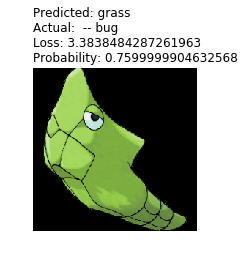

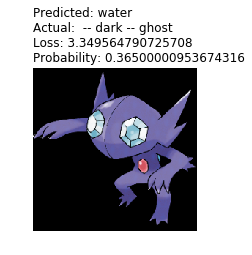

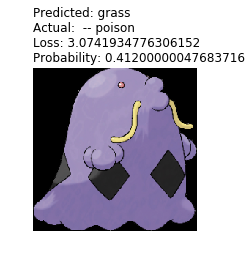

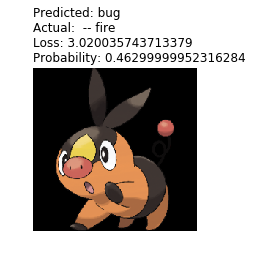

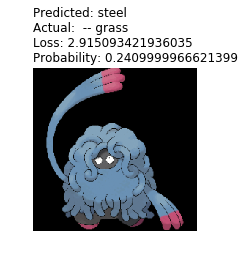

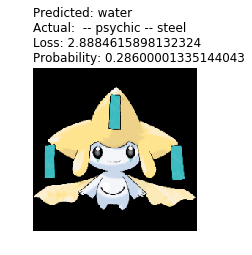

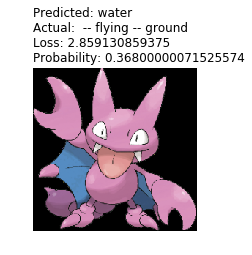

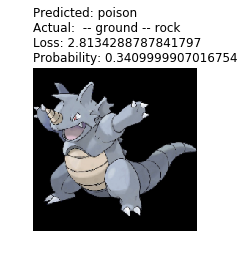

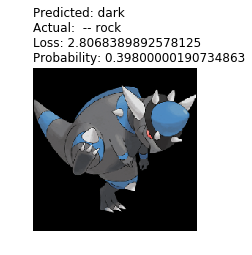

In [31]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_multi_top_losses(9, figsz=(3, 3))

In [32]:
learn50.save('stage-1')

In [33]:
learn50.unfreeze()
learn50.fit_one_cycle(3, max_lr=slice(1e-6,5e-3))

epoch,train_loss,valid_loss,fbeta
1,0.211191,0.233664,0.427468
2,0.192243,0.233511,0.420270
3,0.173708,0.230903,0.400960


70 misclassified samples over 140 samples in the validation set.


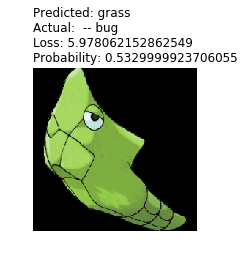

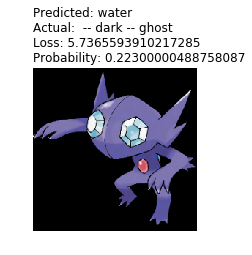

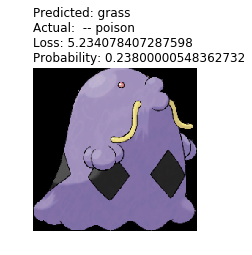

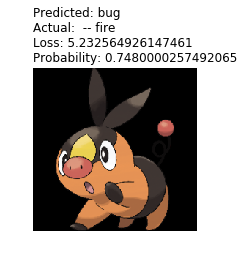

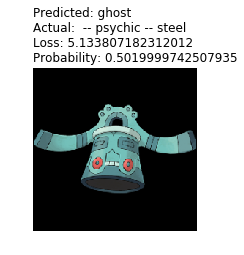

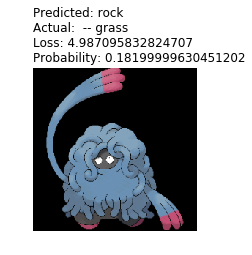

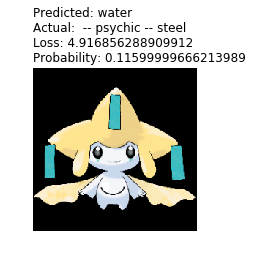

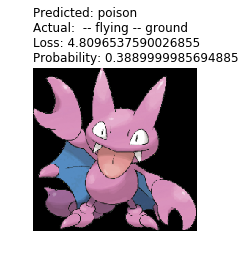

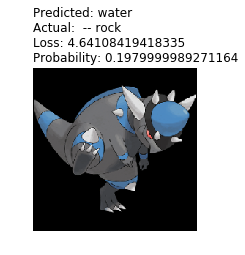

In [34]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_multi_top_losses(9, figsz=(3, 3))

In [35]:
learn50.save('stage-2')